In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn
import yellowbrick
import re
import mglearn
import boto3
from s3 import get_file

In [2]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='0320_2020_nlp.csv')

In [3]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')
df_demo = df.copy().dropna()

In [4]:
#df_copy = df_copy.drop(columns=['instrumentalness','key','mode','liveness','speechiness','time_signature'])

In [5]:
df_demo.sample()

,artist_uri,artist_name,track_name,track_uri,lyrics,acousticness,danceability,energy,valence,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
43767,6yd6lB5T20BZjUVkSlwojA,Bracket,yori yori,1zPbuWCj1bx0MyDUdFnTF8,"INTRO Love love , ; , yori yori , chineke meh ...",0.523,0.685,0.783,0.938,0.0,9.0,0.112,-1.606,0.0,0.169,102.62,4.0


In [6]:
#make_playlist = check_playlist.sample(20)

In [7]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 100 #500
max_df = .10



#LDA
n_components = 5  #10


#LDA Display
display_n_chunks = 5 #5
n_components = 5        #20
n_words = 20       #5



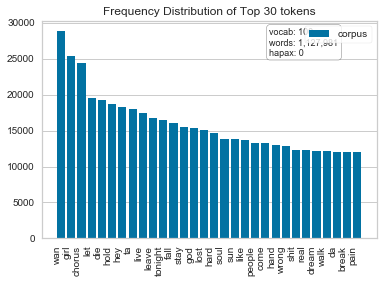

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
docs      = vect.fit_transform(df_demo['lyrics'])
features   = vect.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

## Topic Analysis

In [9]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['lyrics'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_components, learning_method="batch",
                                max_iter=15, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)#[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





In [ ]:
def get_playlist_elements(components=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    topics_words = []
    for i in range(0, len(components), topics_per_chunk):
        # for each chunk:
        these_topics = components[i: i + topics_per_chunk]
        for t in these_topics:
            topic_words = []
            for i in range(n_words):
                try:
                    #print(("{:<14}" * len_this_chunk).format(
                    #    *feature_names[sorting[these_topics, i]]))
                    topics_words.append({'topic':f'topic{t}','word':feature_names[sorting[these_topics, i]][t]})
                except:
                    pass
        
    return topics_words

In [ ]:
playlist_elements = get_playlist_elements()

In [ ]:
df_playlist_elements = pd.DataFrame(playlist_elements)

In [ ]:
list_df_words = df_playlist_elements['word'].tolist()
list_df_topics = set(df_playlist_elements['topic'].tolist())

In [ ]:
def find_lyrics(lyrics,element,track_uri):
    if(lyrics.find(element)!= -1):
        return track_uri
    else:
        return None


In [ ]:
def make_ssp(topics,words):
    topics_words = df_playlist_elements.copy()
    df_lyrics = df_demo.copy()
    df_empty = pd.DataFrame()
    
    ssp = []
    
    #Set df_demo_ssp to topic number

    topics_words = topics_words[(topics_words['topic']== f'topic{topic}')]
    df_demo_ssp_wordset = topics_words['word'].tolist()

    for word in df_demo_ssp_wordset:
        df_empty[f'{word}'] = df_lyrics.apply(lambda x: find_lyrics(x['lyrics'],word,x['track_uri']),axis=1)



    return df_empty


In [ ]:
list_ssp = []
for topic in range(len(list_df_topics)):
    ssp = make_ssp(topic,list_df_words)

    df_ssp = ssp.dropna(how='all')
    for x in range(100):
        for col in df_ssp.columns:
            df_ssp_col = df_ssp[col].dropna(how='any')
            col_track_uri = df_ssp_col.sample(1).values
            list_ssp.append({'playlist':f'topic{topic}playlist{x}','track_uri':col_track_uri[0]})


In [ ]:
sample_ssp = pd.DataFrame(list_ssp)
df_sample_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri').groupby('playlist').median()

In [ ]:
df_sample_ssp.describe()

In [ ]:
df_sample_ssp.to_csv('Data/test_ssp.csv',sep='|',index=True)

## Visualization (Valence Curve, Energy Curve)

df_ssp.plot.line(x='valence',y='energy')

## Create Spotify Playlist

import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    sp_playlist = spotipy.Spotify(auth=token_playlist)
else:
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'
token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)

def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


user_id = get_user_id('https://api.spotify.com/v1/me')

identification = user_id
identification

playlist = sp_playlist.user_playlist_create(identification,'SSP_Ideal', public=False, description="Ideal SSP")

playlist

playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],make_playlist['track_uri'], position=None)

## unigrams

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)